In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

# To view the entire dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Optuna Logging
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING) # To disable displaying trial results in hyperparameter tuning

# Read the data

In [2]:
borough = "Queens" # "Manhattan" "Brooklyn" "Queens" "Staten Island" "Bronx" "EWR"
filename = rf"../../data/with_feature_engineering_totaled/{borough} - all txns.parquet.gz" #
df = pd.read_parquet(filename)

# Get the feature column
target_col = "num_txns_All"
df.head()

,txn_date,quarter,month,day_of_month,txn_hour,week_day,is_weekend,is_monday,is_friday,is_holiday,is_holiday_next_day,is_holiday_previous_day,is_long_weekend,is_rush_hour,is_business_hour,is_night_hour,sin_hour,cos_hour,num_txns_All,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_72,lag_96,lag_120,lag_144,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_68,lag_69,lag_70,lag_71,lag_73,lag_139,lag_140,lag_141,lag_142,lag_143,lag_145,lag_336,lag_504,lag_672,lag_840,lag_1008,lag_1176,lag_1344,rolling_avg_24_48_72_lags,std_24_48_72_lags,rolling_avg_w1-w4_lags,std_w1-w4_lags
timestamp_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,2019-02-01,1,2,1,0,5,1,0,0,0,0.0,0.0,0,0,0,1,0.000000,1.000000,28995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 01:00:00,2019-02-01,1,2,1,1,5,1,0,0,0,0.0,0.0,0,0,0,1,0.258819,0.965926,17045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 02:00:00,2019-02-01,1,2,1,2,5,1,0,0,0,0.0,0.0,0,0,0,1,0.500000,0.866025,10795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 03:00:00,2019-02-01,1,2,1,3,5,1,0,0,0,0.0,0.0,0,0,0,1,0.707107,0.707107,8321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 04:00:00,2019-02-01,1,2,1,4,5,1,0,0,0,0.0,0.0,0,0,0,1,0.866025,0.500000,9153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-Test split

We use January 2023 to July 2024 data as the training set and August 2024 as the test/holdout set.

In [3]:
from sklearn.preprocessing import StandardScaler

# Training data
df_train = (
    df
    [(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]
    .drop("txn_date", axis=1)
    #.dropna()
)
X_train = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]

# Holdout data
df_test = (
    df
    [df['txn_date'] >= "2024-08-01"]
    .drop("txn_date", axis=1)
    .fillna(0) # is_holiday_next_day is causing NULLs since the information of the next days at the edges of the dataframe are unavailable
)

X_test = df_test.drop(target_col, axis=1).to_numpy()
y_test = df_test[target_col].to_numpy()

# Initialize StandardScaler
scaler = StandardScaler()

# Apply the standard scaler
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test set
X_test_scaled = scaler.transform(X_test)

# Feature names
feature_names = df_train.drop(target_col, axis=1).columns.to_list()

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
# Get columns with nulls in both train and test dataframes
train_nulls = df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)
test_nulls = df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

print("Train Dataframe Null Columns:")
print(train_nulls)
print("\nTest Dataframe Null Columns:")
print(test_nulls)

Train Dataframe Null Columns:
Series([], dtype: int64)

Test Dataframe Null Columns:
Series([], dtype: int64)


<Axes: xlabel='timestamp_hour'>

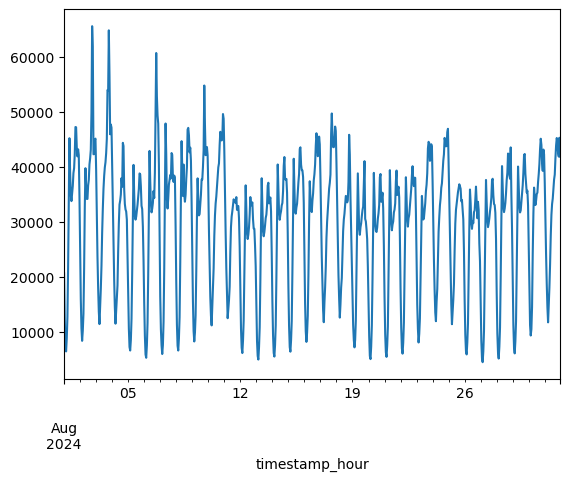

In [5]:
# Print the test set

df_test[target_col].plot()

# Modeling

### Evaluation helper function

In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# MASE
def calculate_mase(y_true, y_pred, hours_per_week=168):
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    
    # Calculate errors for the actual predictions
    prediction_errors = np.abs(y_true - y_pred)
    
    # Calculate naive forecast errors
    if len(y_true) <= hours_per_week:
        raise ValueError(f"Length of y_true must be greater than hours_per_week ({hours_per_week})")
    
    # Calculate week-over-week naive forecast errors
    naive_errors = []
    for i in range(hours_per_week, len(y_true)):
        naive_forecast = y_true[i - hours_per_week]  # Use value from previous week
        naive_errors.append(abs(y_true[i] - naive_forecast))
    
    naive_errors = np.array(naive_errors)
    mean_naive_error = np.mean(naive_errors)
    
    if mean_naive_error == 0:
        raise ValueError("Mean naive error is zero, MASE cannot be computed")
    
    # Calculate MASE
    # For seasonal naive, we only consider errors after the first week
    mase = np.mean(prediction_errors[hours_per_week:]) / mean_naive_error
    
    return mase


# We use this helper function to evaluate model performance
def evaluate(y_true, y_pred):
    """
    This helper function prints the performance metrics of the model
    """
    # Evaluate the model using RMSE and MAE
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase = calculate_mase(y_true, y_pred)

    # Print the model metrics
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print(f'MAPE: {mape}')
    print(f'MASE: {mase}\n')

    return {'RMSE': rmse, 'MAPE': mape, 'MASE': mase, 'MAE': mae, 'MSE': mse,  'R2': r2}

In [8]:
import xgboost
import joblib
xgb = joblib.load('../../models/manhattan_xgboost.pkl')
xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7514441439068051, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.13430446949351468,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0331068613363507,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
X_train.head()

,quarter,month,day_of_month,txn_hour,week_day,is_weekend,is_monday,is_friday,is_holiday,is_holiday_next_day,is_holiday_previous_day,is_long_weekend,is_rush_hour,is_business_hour,is_night_hour,sin_hour,cos_hour,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_72,lag_96,lag_120,lag_144,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_68,lag_69,lag_70,lag_71,lag_73,lag_139,lag_140,lag_141,lag_142,lag_143,lag_145,lag_336,lag_504,lag_672,lag_840,lag_1008,lag_1176,lag_1344,rolling_avg_24_48_72_lags,std_24_48_72_lags,rolling_avg_w1-w4_lags,std_w1-w4_lags
timestamp_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,1,1,1,0,0,0,1,0,1,1.0,0.0,1,0,0,1,0.000000,1.000000,34387.0,38902.0,39080.0,37349.0,38649.0,42819.0,42455.0,41158.0,38922.0,36988.0,34389.0,33324.0,31196.0,30173.0,28458.0,27035.0,24941.0,18759.0,14234.0,10156.0,9097.0,9735.0,12019.0,16533.0,24331.0,20151.0,16677.0,14701.0,19012.0,9858.0,13014.0,17292.0,22986.0,28944.0,34736.0,7506.0,7220.0,8796.0,12469.0,27479.0,7493.0,6558.0,6517.0,8190.0,12148.0,26234.0,48019.0,48529.0,47897.0,32518.0,45838.0,46512.0,44813.0,26289.666667,7317.322279,43347.25,9606.067818
2023-01-01 01:00:00,1,1,1,1,0,0,1,0,1,1.0,0.0,1,0,0,1,0.258819,0.965926,26005.0,34387.0,38902.0,39080.0,37349.0,38649.0,42819.0,42455.0,41158.0,38922.0,36988.0,34389.0,33324.0,31196.0,30173.0,28458.0,27035.0,24941.0,18759.0,14234.0,10156.0,9097.0,9735.0,12019.0,16533.0,12469.0,10496.0,9223.0,12148.0,8112.0,9858.0,13014.0,17292.0,22986.0,28944.0,9568.0,7506.0,7220.0,8796.0,20151.0,10324.0,7493.0,6558.0,6517.0,8190.0,19012.0,39856.0,41849.0,39068.0,25928.0,37093.0,40650.0,63517.0,18335.666667,6945.720217,35939.75,8714.773601
2023-01-01 02:00:00,1,1,1,2,0,0,1,0,1,1.0,0.0,1,0,0,1,0.500000,0.866025,20757.0,26005.0,34387.0,38902.0,39080.0,37349.0,38649.0,42819.0,42455.0,41158.0,38922.0,36988.0,34389.0,33324.0,31196.0,30173.0,28458.0,27035.0,24941.0,18759.0,14234.0,10156.0,9097.0,9735.0,12019.0,8796.0,6972.0,6472.0,8190.0,9312.0,8112.0,9858.0,13014.0,17292.0,22986.0,14117.0,9568.0,7506.0,7220.0,12469.0,12373.0,10324.0,7493.0,6558.0,6517.0,12148.0,30590.0,31663.0,29289.0,20587.0,28322.0,31440.0,19956.0,13857.333333,6188.778743,27208.50,6681.880100
2023-01-01 03:00:00,1,1,1,3,0,0,1,0,1,1.0,0.0,1,0,0,1,0.707107,0.707107,16680.0,20757.0,26005.0,34387.0,38902.0,39080.0,37349.0,38649.0,42819.0,42455.0,41158.0,38922.0,36988.0,34389.0,33324.0,31196.0,30173.0,28458.0,27035.0,24941.0,18759.0,14234.0,10156.0,9097.0,9735.0,7220.0,5921.0,5470.0,6517.0,11269.0,9312.0,8112.0,9858.0,13014.0,17292.0,18579.0,14117.0,9568.0,7506.0,8796.0,14389.0,12373.0,10324.0,7493.0,6558.0,8190.0,23370.0,23414.0,21815.0,16599.0,21664.0,23845.0,15007.0,11211.666667,4899.827378,20403.25,4981.976674
2023-01-01 04:00:00,1,1,1,4,0,0,1,0,1,1.0,0.0,1,0,0,1,0.866025,0.500000,12430.0,16680.0,20757.0,26005.0,34387.0,38902.0,39080.0,37349.0,38649.0,42819.0,42455.0,41158.0,38922.0,36988.0,34389.0,33324.0,31196.0,30173.0,28458.0,27035.0,24941.0,18759.0,14234.0,10156.0,9097.0,7506.0,6687.0,6257.0,6558.0,11966.0,11269.0,9312.0,8112.0,9858.0,13014.0,25715.0,18579.0,14117.0,9568.0,7220.0,18030.0,14389.0,12373.0,10324.0,7493.0,6517.0,16744.0,16609.0,14947.0,12600.0,15645.0,16667.0,12130.0,9677.666667,2512.831935,14539.50,3226.202566


In [12]:
# Train the best model
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Model evaluation
print("Train")
xgb_eval_metrics_train = evaluate(y_train, xgb.predict(X_train))
print("Test")
xgb_eval_metrics_test = evaluate(y_test, y_pred)

Train
MAE: 361.91359083270254
MSE: 430438.61815275025
RMSE: 656.0782103932048
R2: 0.9975369937800175
MAPE: 27.730919385144375
MASE: 0.1308738768907056

Test
MAE: 1479.4810922274025
MSE: 5433475.173035175
RMSE: 2330.981590024935
R2: 0.9617889189186668
MAPE: 4.880752418950185
MASE: 0.7078096682228862



In [30]:
import pendulum
test_dt = pendulum.parse('2024-08-01')
scoring_dt = [test_dt.subtract(days=1)]
for i in range(1,90):
    scoring_dt.append(test_dt.subtract(days=i))

In [33]:
xgb_eval_metrics_test

{'RMSE': 2325.227333706238,
 'MAPE': 4.883401995399253,
 'MASE': 0.7050027897901846,
 'MAE': 1471.01120749853,
 'MSE': 5406682.15341462,
 'R2': 0.9619773416522822}

In [64]:

rmse = []
mape = []
mase = []
mae = []
mse = []
r2 = []

for dt in scoring_dt:

    print(f"Scoring Date on {dt.add(days = 1).to_date_string()} for August 2024")

    dt_start = dt.subtract(months = 18).strftime('%Y-%m-%d %H:%M:%S')
    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    xgb.fit(X_train[dt_start:dt], y_train[dt_start:dt])

    y_pred = xgb.predict(X_test)
    
    # Model evaluation
    #print("Train")
    #xgb_eval_metrics_train = evaluate(y_train[y_train.index<=dt], xgb.predict(X_train[X_train.index<=dt]))
    results = evaluate(y_test, y_pred)
    rmse.append(results['RMSE'])
    mape.append(results['MAPE'])
    mase.append(results['MASE'])
    r2.append(results['R2'])

Scoring Date on 2024-08-01 for August 2024
MAE: 1468.699236469884
MSE: 5314413.10712063
RMSE: 2305.301088170617
R2: 0.9626262265550298
MAPE: 4.892266413238691
MASE: 0.6972754933687443

Scoring Date on 2024-07-31 for August 2024
MAE: 1464.1115420761928
MSE: 5292952.51773161
RMSE: 2300.641762146295
R2: 0.9627771488092194
MAPE: 4.875054694896353
MASE: 0.7008584147560477

Scoring Date on 2024-07-30 for August 2024


KeyboardInterrupt: 

In [55]:
dt_string = [i.to_date_string() for i in scoring_dt]
dt_string

['2024-07-31',
 '2024-07-30',
 '2024-07-29',
 '2024-07-28',
 '2024-07-27',
 '2024-07-26',
 '2024-07-25',
 '2024-07-24',
 '2024-07-23',
 '2024-07-22',
 '2024-07-21',
 '2024-07-20',
 '2024-07-19',
 '2024-07-18',
 '2024-07-17',
 '2024-07-16',
 '2024-07-15',
 '2024-07-14',
 '2024-07-13',
 '2024-07-12',
 '2024-07-11',
 '2024-07-10',
 '2024-07-09',
 '2024-07-08',
 '2024-07-07',
 '2024-07-06',
 '2024-07-05',
 '2024-07-04',
 '2024-07-03',
 '2024-07-02',
 '2024-07-01',
 '2024-06-30',
 '2024-06-29',
 '2024-06-28',
 '2024-06-27',
 '2024-06-26',
 '2024-06-25',
 '2024-06-24',
 '2024-06-23',
 '2024-06-22',
 '2024-06-21',
 '2024-06-20',
 '2024-06-19',
 '2024-06-18',
 '2024-06-17',
 '2024-06-16',
 '2024-06-15',
 '2024-06-14',
 '2024-06-13',
 '2024-06-12',
 '2024-06-11',
 '2024-06-10',
 '2024-06-09',
 '2024-06-08',
 '2024-06-07',
 '2024-06-06',
 '2024-06-05',
 '2024-06-04',
 '2024-06-03',
 '2024-06-02',
 '2024-06-01',
 '2024-05-31',
 '2024-05-30',
 '2024-05-29',
 '2024-05-28',
 '2024-05-27',
 '2024-05-

In [51]:
results_df = pd.DataFrame(dt_string)
results_df['RMSE_2024-0']

,0
0,2024-07-31
1,2024-07-30
2,2024-07-29
3,2024-07-28
4,2024-07-27
5,2024-07-26
6,2024-07-25
7,2024-07-24
8,2024-07-23
9,2024-07-22


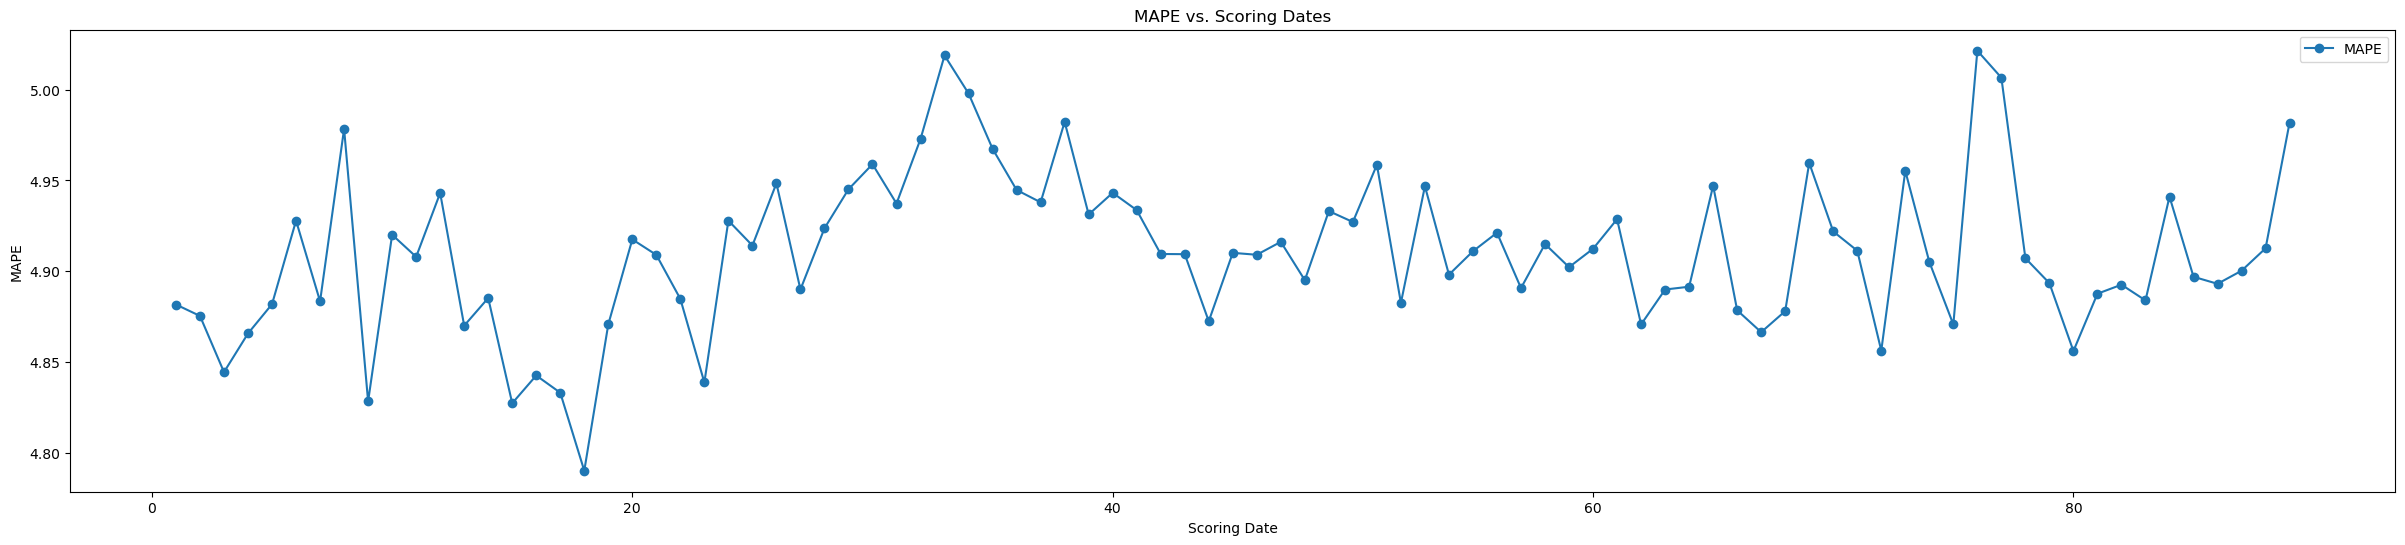

In [58]:
plt.figure(figsize=(30, 6))

plt.plot(range(1,90), mape, marker='o', label='MAPE')
plt.xlabel('Scoring Date')
plt.ylabel('MAPE')
plt.title('MAPE vs. Scoring Dates')
#plt.xticks(rotation=45)
plt.legend()
plt.show()

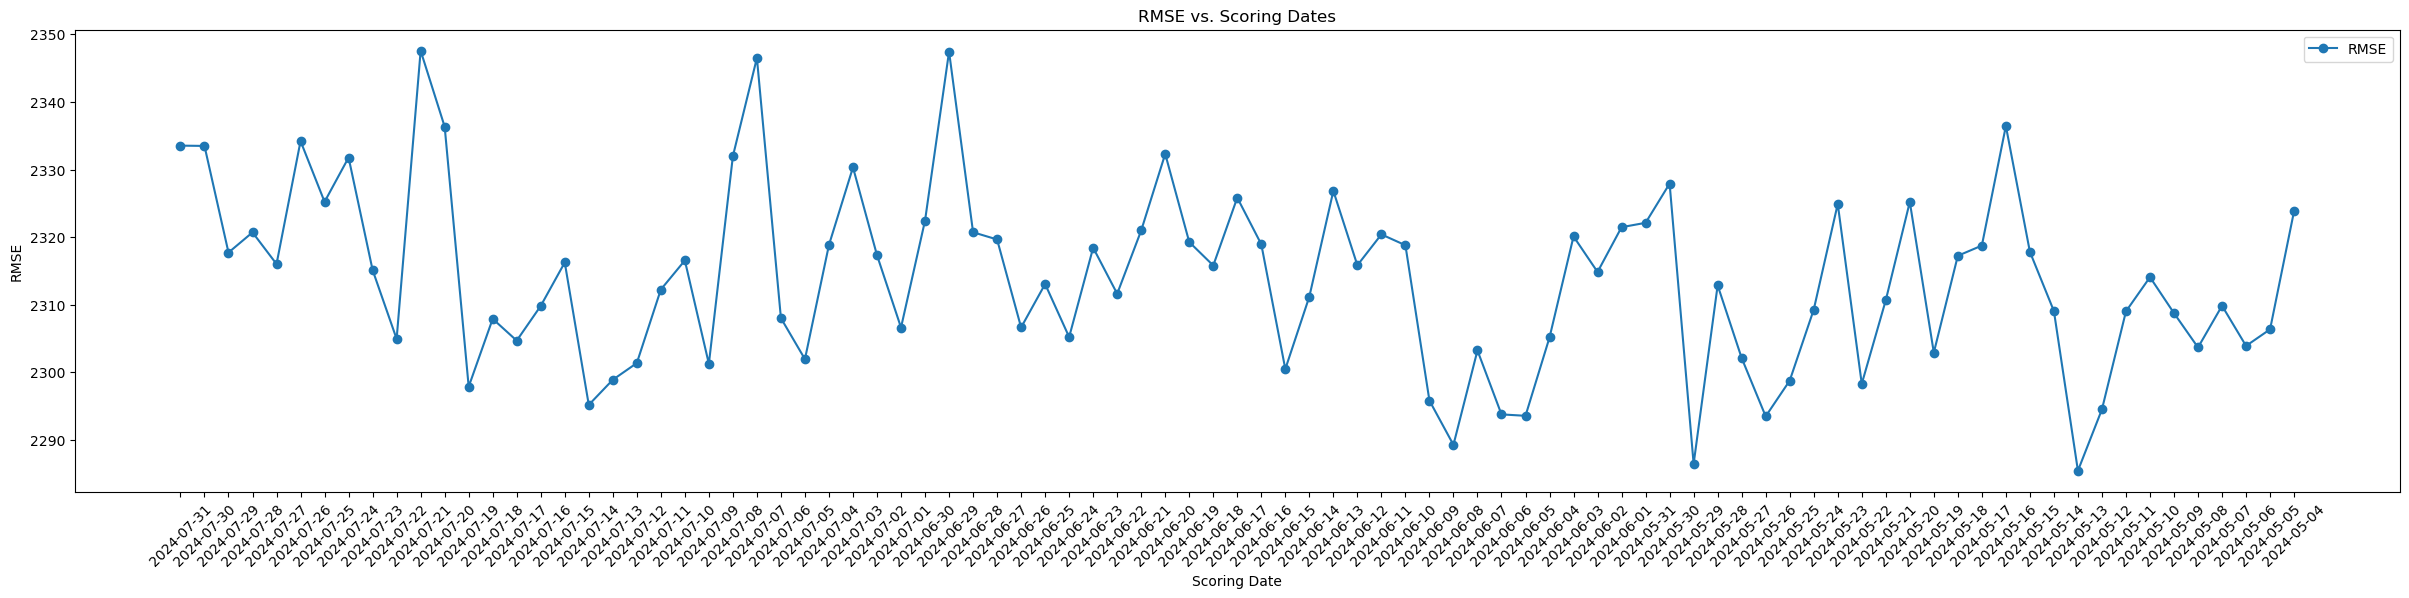

In [53]:
plt.figure(figsize=(30, 6))

plt.plot(dt_string, rmse, marker='o', label='RMSE')
plt.xlabel('Scoring Date')
plt.ylabel('RMSE')
plt.title('RMSE vs. Scoring Dates')
plt.xticks(rotation=45)
plt.legend()
plt.show()

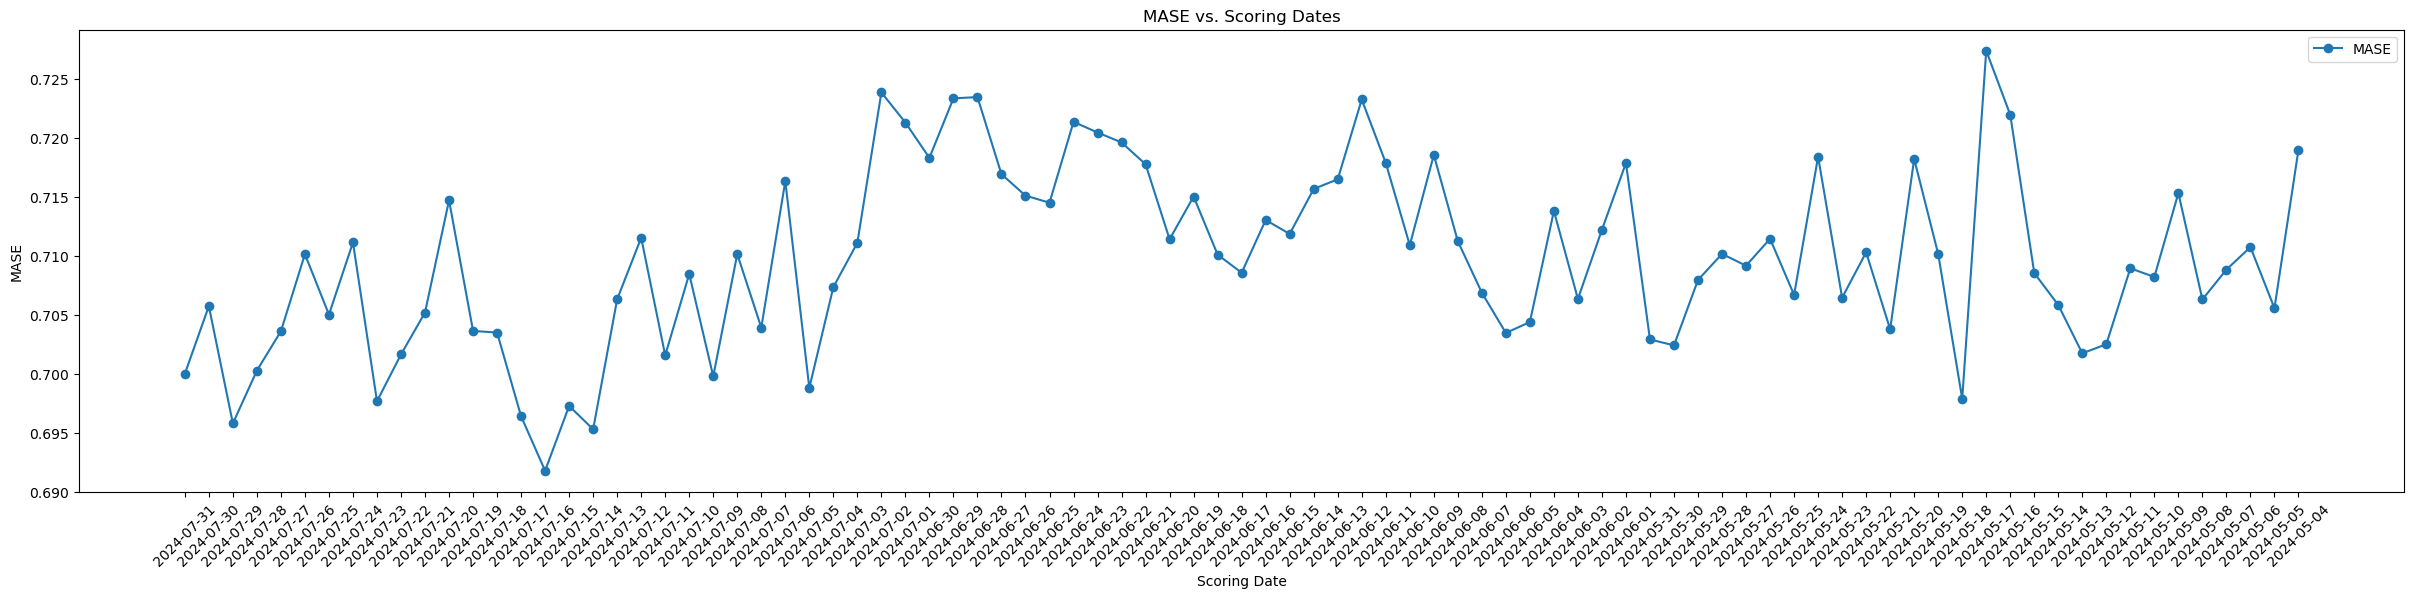

In [54]:
plt.figure(figsize=(30, 6))

plt.plot(dt_string, mase, marker='o', label='MASE')
plt.xlabel('Scoring Date')
plt.ylabel('MASE')
plt.title('MASE vs. Scoring Dates')
plt.xticks(rotation=45)
plt.legend()
plt.show()

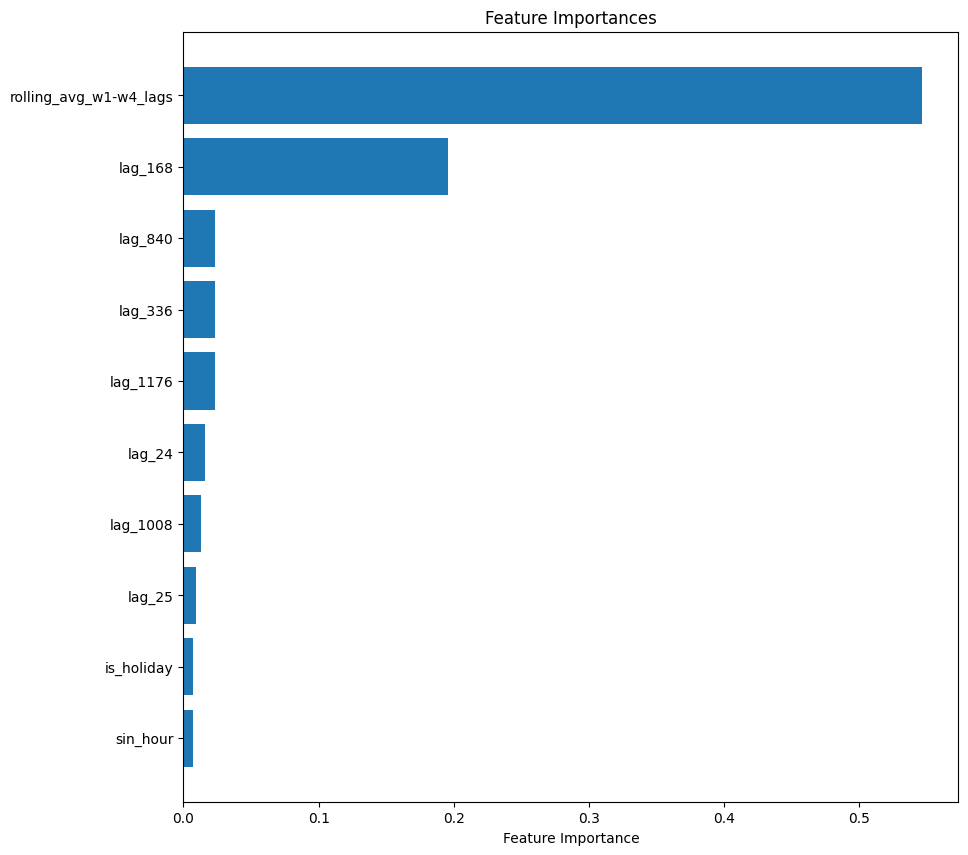

In [14]:
feature_impt = dict(zip(feature_names, xgb_model.feature_importances_))

# Sort the dictionary by feature importance in descending order
k = 10
top_k_importance = dict(sorted(feature_impt.items(), 
                                key=lambda item: item[1], reverse=True)[:k])

# Extract the feature names and importances for plotting
features = list(top_k_importance.keys())[::-1]
importances = list(top_k_importance.values())[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.savefig("../../data/images/Manhattan - XGBoost model feature importances.jpeg", dpi=300, bbox_inches='tight')
plt.show()

#### SHAP on XGBoost model

[01:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


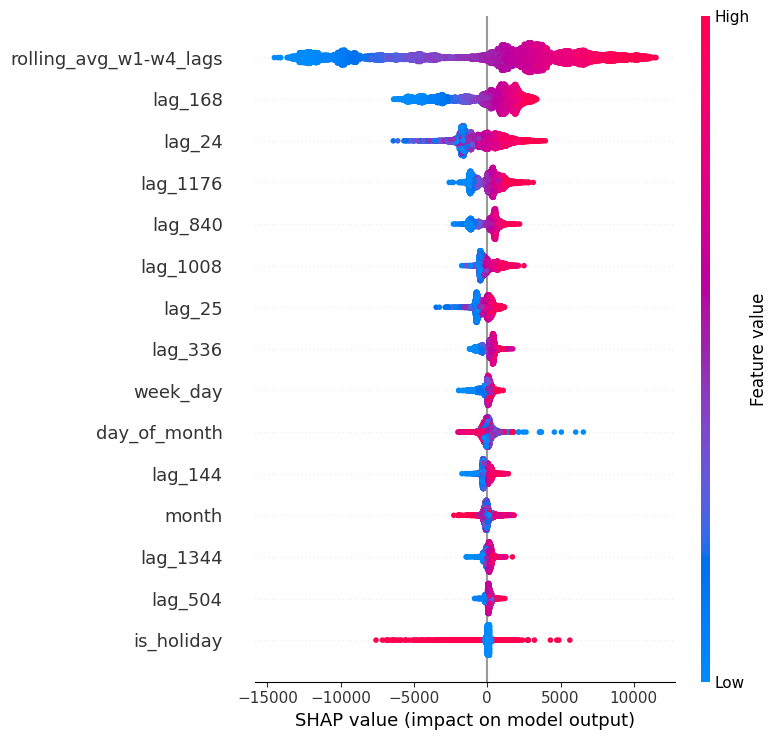

In [15]:
import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model, n_jobs=-1)

# Compute SHAP values for the dataset (assuming X_train is your input data)
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values (feature importances)
#fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False, max_display=15)

# Save the plot as a JPEG file
plt.savefig(r"../../data/images/Manhattan - XGBoost model SHAP beeswarm plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()

### Deep Neural Network

In [16]:
from sklearn.neural_network import MLPRegressor

# Fit the regression model
nn_model = MLPRegressor(hidden_layer_sizes=(80, 100, 120, 80), 
                        activation="relu",
                        solver="adam", 
                        learning_rate="adaptive",
                        learning_rate_init=0.08,
                        momentum=0.9,
                        max_iter=500,
                        tol=1e-7,
                        random_state=42, 
                        verbose=True,
                        shuffle=False # NOTE THAT THIS IS TIME SERIES DATA NO SHUFFLING ALLOWED
                       )
nn_model.fit(X_train_scaled, y_train) # Use scaled data

# Make predictions
y_pred_nn = nn_model.predict(X_test_scaled) # Use scaled data

# Model evaluation
print("Train")
nn_eval_metrics_train = evaluate(y_train, nn_model.predict(X_train_scaled))
print("Test")
nn_eval_metrics_test = evaluate(y_test, y_pred_nn)

Iteration 1, loss = 57309521.83716043
Iteration 2, loss = 28339638.45670440
Iteration 3, loss = 32826151.78224602
Iteration 4, loss = 18873158.90222052
Iteration 5, loss = 12761364.29968359
Iteration 6, loss = 11458922.31403817
Iteration 7, loss = 10075722.15123278
Iteration 8, loss = 8813904.35172035
Iteration 9, loss = 8030465.17024252
Iteration 10, loss = 7829186.24890575
Iteration 11, loss = 7856040.80799670
Iteration 12, loss = 7900048.45468889
Iteration 13, loss = 7554669.03290306
Iteration 14, loss = 7047721.33930168
Iteration 15, loss = 6749614.59912753
Iteration 16, loss = 6587702.53279652
Iteration 17, loss = 6924294.12451578
Iteration 18, loss = 7147859.62320108
Iteration 19, loss = 7678224.76530381
Iteration 20, loss = 7953128.43122690
Iteration 21, loss = 8072169.49404079
Iteration 22, loss = 6509354.63768928
Iteration 23, loss = 5702085.57858093
Iteration 24, loss = 5183786.26636988
Iteration 25, loss = 4905394.72217974
Iteration 26, loss = 4894423.77723158
Iteration 27, 

### FB Prophet

### GARCH

# Model Comparisons

### Time Series Plots

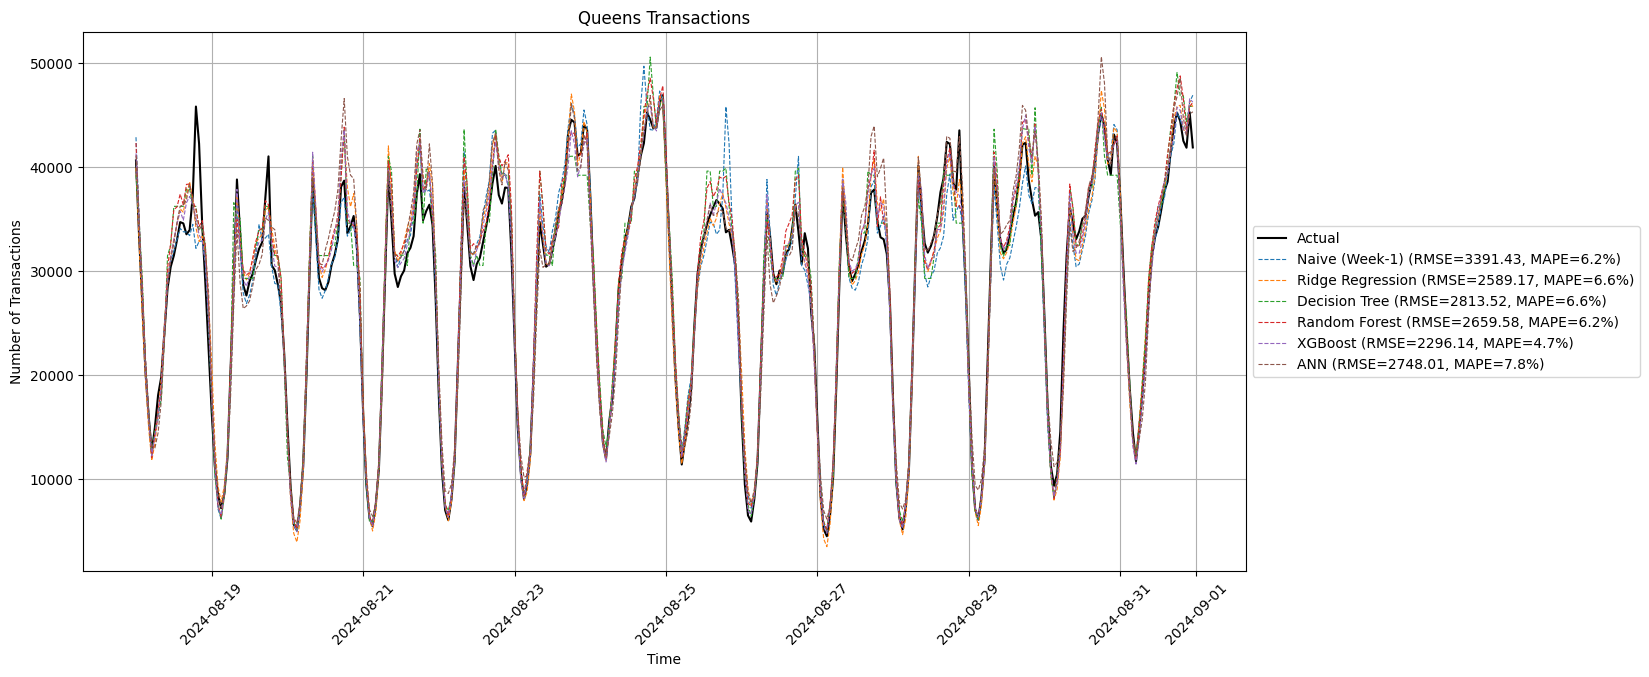

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

num_hrs = 168 * 2 # plot only the last 2 weeks
# Plotting the predictions
ax.plot(df_test.index[-num_hrs:], df_test[target_col][-num_hrs:], label="Actual", color='black', lw=1.5)
ax.plot(df_test.index[-num_hrs:], df_naive["forecast_w-1"][-num_hrs:], label=f"Naive (Week-1) (RMSE={naive_eval_metrics_test['RMSE']:.2f}, MAPE={naive_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_ridge[-num_hrs:], label=f"Ridge Regression (RMSE={ridge_eval_metrics_test['RMSE']:.2f}, MAPE={ridge_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_dt[-num_hrs:], label=f"Decision Tree (RMSE={dt_eval_metrics_test['RMSE']:.2f}, MAPE={dt_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_rf[-num_hrs:], label=f"Random Forest (RMSE={rf_eval_metrics_test['RMSE']:.2f}, MAPE={rf_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_xgboost[-num_hrs:], label=f"XGBoost (RMSE={xgb_eval_metrics_test['RMSE']:.2f}, MAPE={xgb_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_nn[-num_hrs:], label=f"ANN (RMSE={nn_eval_metrics_test['RMSE']:.2f}, MAPE={nn_eval_metrics_test['MAPE']:.1f}%)", ls='--', lw=.8)

# Adding labels, title, and legend for better clarity
ax.set_xlabel('Time')
ax.set_ylabel('Number of Transactions')
ax.set_title(f'{borough} Transactions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels 45 degrees

img_filename = rf"../../data/results/{borough} - test set performance comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show()

### Model Performance

In [18]:
# Create a dictionary mapping model names to their metrics
models_dict = {
    'Naive (W-1)': naive_eval_metrics_test,
    'Ridge Regression': ridge_eval_metrics_test,
    'Decision Tree': dt_eval_metrics_test,
    'Random Forest': rf_eval_metrics_test,
    'XGBoost': xgb_eval_metrics_test,
    'Neural Network': nn_eval_metrics_test
    # FB Prophet - to be implemented
    # GARCH
}

# Convert to DataFrame
df_metrics = pd.DataFrame.from_dict(models_dict, orient='index')
df_metrics["borough"] = borough
df_metrics = df_metrics[["borough", "RMSE", "MAPE", "MASE"]]

csv_filename = rf"../../data/results/{borough} - model metrics.csv"
df_metrics.to_csv(csv_filename)
df_metrics.head(4)

,borough,RMSE,MAPE,MASE
Naive (W-1),Queens,3391.432994,6.210400,1.000000
Ridge Regression,Queens,2589.167760,6.604745,0.858128
Decision Tree,Queens,2813.515353,6.579867,0.976233
Random Forest,Queens,2659.582415,6.173092,0.908444


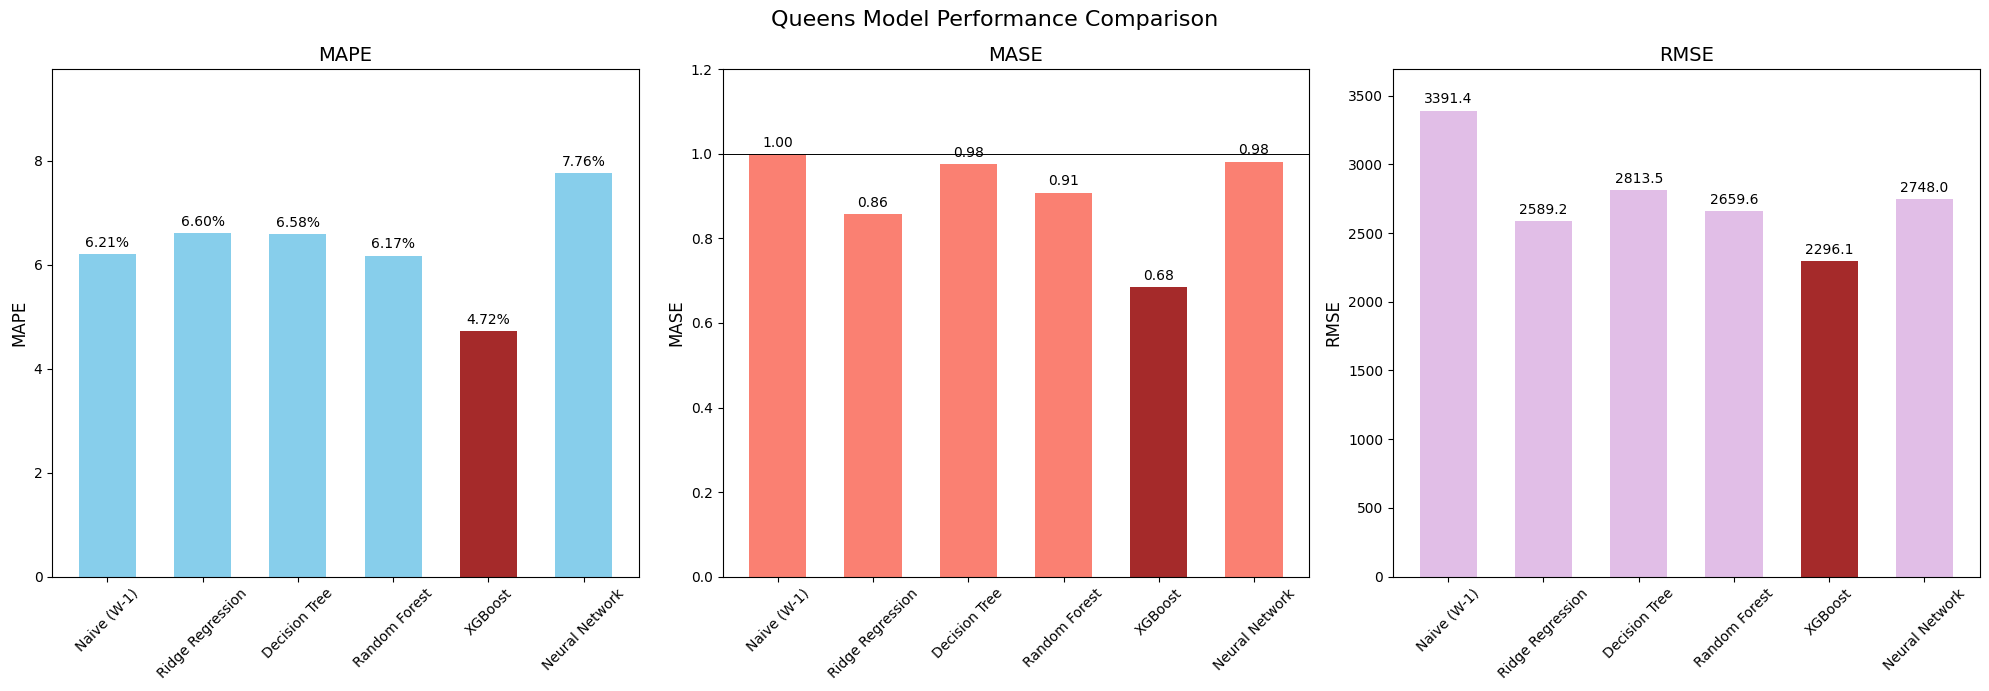

In [19]:
# Bar plots for MAPE and MASE
x = np.arange(len(df_metrics.index))  # the label locations

# Subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Highlight only the XGBoost bar
colors_mape = ['skyblue' if model != 'XGBoost' else '#A52A2A' for model in df_metrics.index]
colors_mase = ['salmon' if model != 'XGBoost' else '#A52A2A' for model in df_metrics.index]
colors_rmse = ['#E1BEE7' if model != 'XGBoost' else '#A52A2A' for model in df_metrics.index]

# Subplot 1: MAPE
axes[0].bar(x, df_metrics['MAPE'], color=colors_mape, width=0.6)
axes[0].set_title('MAPE', fontsize=14)
axes[0].set_ylabel('MAPE', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[0].bar_label(axes[0].containers[0], fmt='%.2f%%', padding=3)
axes[0].set_ylim(0, df_metrics['MAPE'].max() + 2)

# Subplot 2: MASE
axes[1].bar(x, df_metrics['MASE'], color=colors_mase, width=0.6)
axes[1].axhline(y=1, color='black', lw=.7)
axes[1].set_title('MASE', fontsize=14)
axes[1].set_ylabel('MASE', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', padding=3)
axes[1].set_ylim(0, df_metrics['MASE'].max() + .2)

# Sublot 3: RMSE
axes[2].bar(x, df_metrics['RMSE'], color=colors_rmse, width=0.6)
axes[2].set_title('RMSE', fontsize=14)
axes[2].set_ylabel('RMSE', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[2].bar_label(axes[2].containers[0], fmt='%.1f', padding=3)
axes[2].set_ylim(0, df_metrics['RMSE'].max() + 300)

# Add a suptitle for the entire figure
fig.suptitle(f'{borough} Model Performance Comparison', fontsize=16)

# Adjust layout and show
fig.tight_layout()

# Save the figure
img_filename = rf"../../data/results/{borough} - metrics comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show();

### ADF test and ACF+PACF

In [ ]:
# from statsmodels.tsa.stattools import adfuller

# time_series = df[(df['txn_date'] >= '2023-01-01') & (df['txn_date'] <= '2024-12-01')][target_col].to_numpy()
# result = adfuller(time_series)
# print('ADF Statistic: %f' % result[0])
# print('p-value:', result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))



# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Time series data
# time_series = df[(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]["num_txns_All"]

# # Max time lag 
# lag = 200

# # Tick positions
# tick_positions = np.arange(0, lag + 1, 24)  # From 0 to max(x) in steps of 24
# tick_labels = [int(t) for t in tick_positions]  # Custom labels

# # Plot ACF and PACF
# fig, ax = plt.subplots(2, 1, figsize=(15, 7))

# # Autocorrelation (ACF)
# plot_acf(
#     time_series,
#     ax=ax[0],
#     lags=lag,
#     vlines_kwargs={"linewidth": 0.5},  # Adjust line width
#     markersize=3  # Adjust marker size
# )
# ax[0].set_title(f"{borough} ACF")
# ax[0].set_xlabel("Hours")
# ax[0].set_xticks(tick_positions)  # Set tick positions
# ax[0].set_xticklabels(tick_labels)  # Set custom labels
# ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# # Partial Autocorrelation (PACF)
# plot_pacf(
#     time_series,
#     ax=ax[1],
#     lags=lag,
#     method='ywm',
#     vlines_kwargs={"linewidth": 0.5},  # Adjust line width
#     markersize=3  # Adjust marker size
# )
# ax[1].set_title(f"{borough} PACF")
# ax[1].set_xlabel("Hours")
# ax[1].set_xticks(tick_positions)  # Set tick positions
# ax[1].set_xticklabels(tick_labels)  # Set custom labels
# ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# fig.tight_layout()
# plt.savefig(rf"../../data/images/acf_pacf_{borough}.jpeg", dpi=300)
# plt.show()